<a href="https://colab.research.google.com/github/DmitryCS/vehicle_segmentation/blob/master/Final_just_run_all_cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# УСТАНОВКА ВСЕГО НЕОБХОДИМОГО

In [0]:
%%capture
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1

In [0]:
%%capture
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

In [0]:
import os
if not os.path.exists("./model_final.pth"):
  !wget https://media.githubusercontent.com/media/DmitryCS/vehicle_segmentation/master/model_final.pth    #скачиваем обученные веса

# ИМПОРТ ВСЕГО

In [0]:
import torch, torchvision
import detectron2

import numpy as np
import cv2
import random
from IPython.display import Image 
from google.colab.patches import cv2_imshow

# для регистрации данных
from detectron2.data.datasets import register_coco_instances

# для предиктора
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# для предсказания фото
from detectron2.utils.visualizer import ColorMode
from google.colab.patches import cv2_imshow

# для предсказания видео
from IPython.display import YouTubeVideo, display
import tqdm
from detectron2.utils.video_visualizer import VideoVisualizer

# РЕГИСТРАЦИЯ МЕТАДАННЫХ ДАТАСЕТА

In [0]:
register_coco_instances("my_dataset", {'thing_classes': ['car', 'minibus', 'trolleybus', 'tram', 'truck', 'bus', 'middle_bus', 'ambulance', 'fire_truck', 'middle_truck', 'tractor', 'uncategorized', 'van', 'person']}, "", "")
dataset_metadata = MetadataCatalog.get("my_dataset")

# СОЗДАНИЕ ПРЕДИКТОРА ИЗОБАРЖЕНИЯ

In [0]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("LVIS-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml")) # получение используемой модели 
cfg.MODEL.WEIGHTS = "model_final.pth" # путь к найденным лучшим весам модели
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # установить порог распознавания объекта в 50% (объекты, распознанные с меньшей вероятностью не будут учитываться)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14 # число классов для распознавания

predictor = DefaultPredictor(cfg) 

# ПРЕДСКАЗАНИЕ ФОТО

In [0]:
!wget https://i.ibb.co/CKhyX57/id-921-29.png

--2020-05-27 19:08:03--  https://i.ibb.co/CKhyX57/id-921-29.png
Resolving i.ibb.co (i.ibb.co)... 144.48.105.82, 172.96.140.18, 104.194.8.196
Connecting to i.ibb.co (i.ibb.co)|144.48.105.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3740287 (3.6M) [image/png]
Saving to: ‘id-921-29.png.2’

id-921-29.png.2     100%[===================>]   3.57M  15.7MB/s    in 0.2s    

2020-05-27 19:08:03 (15.7 MB/s) - ‘id-921-29.png.2’ saved [3740287/3740287]



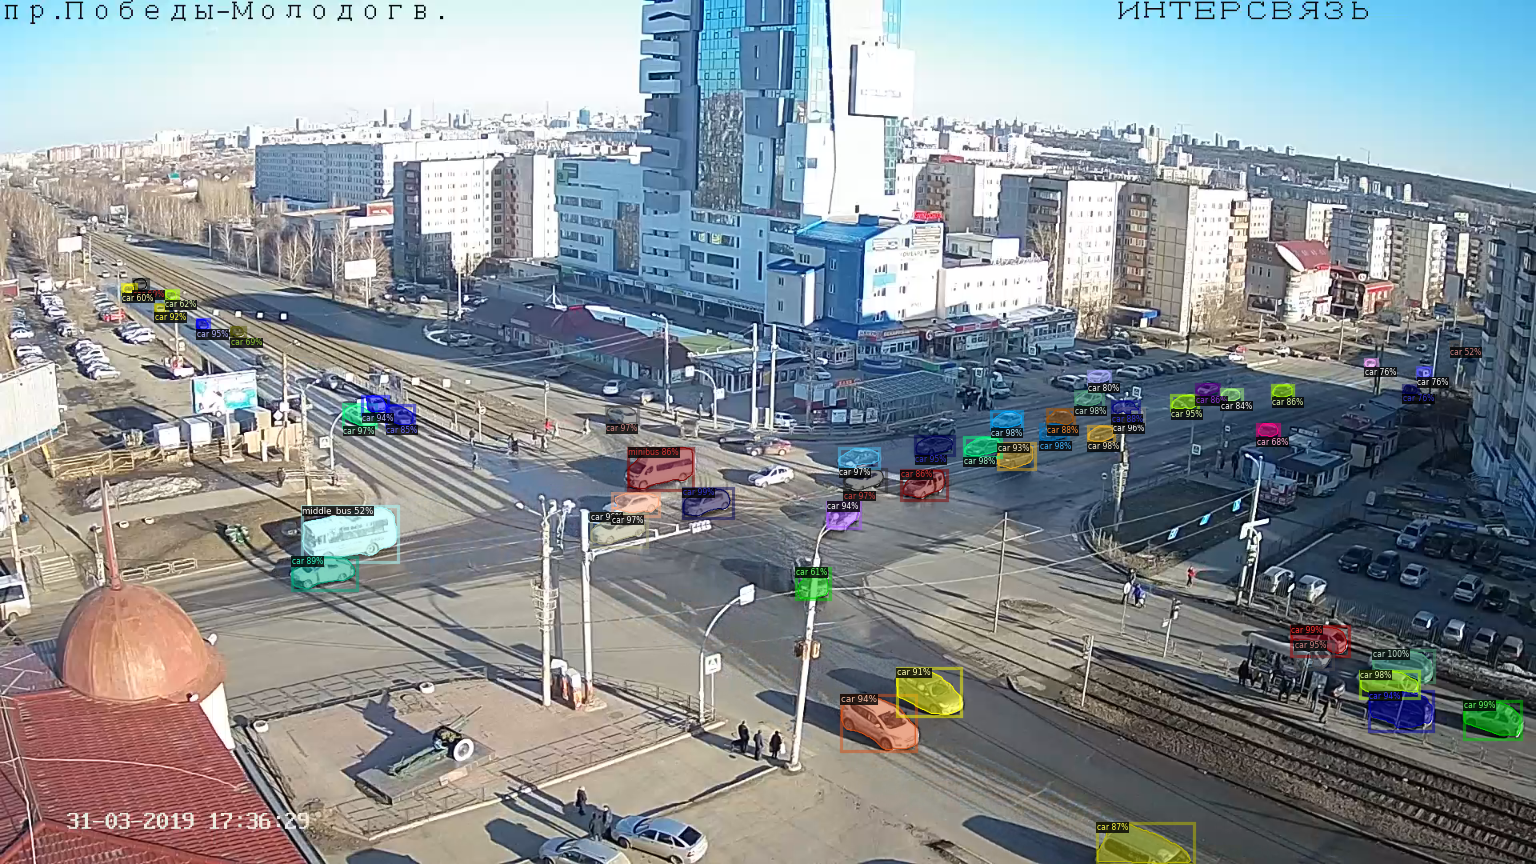

In [0]:
im = cv2.imread("id-921-29.png")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                dataset_metadata, 
                scale=0.8, 
                instance_mode=ColorMode.IMAGE   
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

# ПРЕДСКАЗАНИЕ ВИДЕО

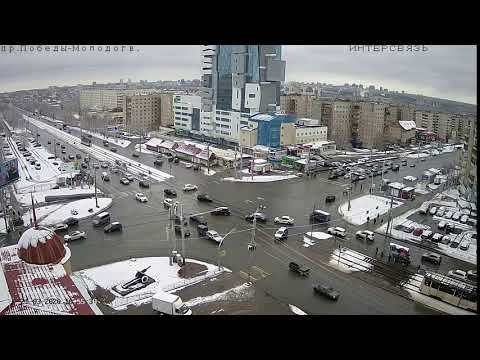

In [0]:
# Отобразим выбранное видео из ютуба
video = YouTubeVideo("3o7aW-lhDWs", width=500)
display(video)

In [0]:
# Скачаем это видео с ютуба
!pip install youtube-dl
!youtube-dl https://www.youtube.com/watch?v=3o7aW-lhDWs -o video.mp4 -f 22 #18

[youtube] 3o7aW-lhDWs: Downloading webpage
[youtube] 3o7aW-lhDWs: Downloading MPD manifest
[download] video.mp4 has already been downloaded
[download] 100% of 1.88MiB


In [0]:
# Функции, необходимые для обработки видеофайла
def _frame_from_video(video):
  while video.isOpened():
      success, frame = video.read()
      if success:
          yield frame
      else:
        break
def run_on_video(video):
        video_visualizer = VideoVisualizer(dataset_metadata, ColorMode.IMAGE)

        def process_predictions(frame, predictions):
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            predictions = predictions["instances"].to("cpu")
            vis_frame = video_visualizer.draw_instance_predictions(frame, predictions)
            # Converts Matplotlib RGB format to OpenCV BGR format
            vis_frame = cv2.cvtColor(vis_frame.get_image(), cv2.COLOR_RGB2BGR)
            return vis_frame

        frame_gen = _frame_from_video(video)
        for frame in frame_gen:
          yield process_predictions(frame, predictor(frame))

In [0]:
# Предсказание видео
video = cv2.VideoCapture("video.mp4")
num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video.get(cv2.CAP_PROP_FPS))

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
output_file = cv2.VideoWriter("video_final.mp4", fourcc, fps, (w,h), True)

frame_gen = _frame_from_video(video)

for vis_frame in tqdm.tqdm(run_on_video(video), total=num_frames):
  output_file.write(vis_frame)  
video.release()
output_file.release()

100%|██████████| 180/180 [03:57<00:00,  1.32s/it]


# ОТОБРАЖЕНИЕ ВИДЕО

In [0]:
%%capture
# сожмем видеофайл для возможности отображения видео прямо в Colab
if os.path.exists("./video_final_compressed.mp4"):
  !rm video_final_compressed.mp4 
!ffmpeg -i video_final.mp4 -q:v 4 video_final_compressed.mp4   

In [0]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video_final_compressed.mp4','rb').read()
data_url = "data:video_final_compressed/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1300 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [0]:
# Для скачивания видео
# from google.colab import files
# files.download("video_final.mp4")